# 긍정, 부정 감성 분석(Sentiment Analysis)
* 감성 분석 : 입력된 자연어 안의 주관적 의견, 감정 등을 찾아내는 문제 
* 극성(polarity) 감성 분석 : 문장의 긍적/부정이나 긍정/중립/부정을 분류
* 영화 리뷰나 음식점 리뷰는 데이터의 양이 많고 별점을 함께 달기 때문에 긍정/중립/부정 라벨링이 쉬워서 극성 감성 분석에 쉽게 적용됨  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### 감성 데이터 불러오기 

In [2]:
path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

#### 데이터 로드 및 확인
* 데이터의 각 행은 \t로 구분
* id : 각 데이터의 고유한 번호
* document : 실제 리뷰 내용
* label : 0은 부정, 1은 긍정

In [3]:
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

# 텍스트가 총 몇 자인지 확인합니다.
print('Length of text: {} characters'.format(len(train_text)))
print('Length of text: {} characters'.format(len(test_text)))
print()

print(train_text[:300])  # 300자 출력하기 

Length of text: 6937271 characters
Length of text: 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


#### 학습을 위한 정답 데이터(Y) 만들기
* 정답은 0 / 1 만 존재
* 첫번째 줄과 두번째 줄은 먼저 각 텍스트를 \n으로 분리한 다음, 헤더에 해당하는 부분을 제외한 나머지([1:])에 대해 각 행을 처리한다. 
* 각 행은 \t로 나눠진 후 2번째 원소를 정수로 변환해서 저장
* 마지막엔 np.array로 결과 리스트를 감싸서 네트워크에 입력하기 쉽게 만들어냄 

In [4]:
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])
print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


#### 훈련 데이터 정제
* 입력으로 사용할 자연어를 토큰화(Tokenization)하고 정제(Cleaning) 해야한다.
* 토큰화 : 자연어를 처리 가능한 작은 단위로 나눈는 것 --> 띄어쓰기 단위로 나눔 
* 정제 : 원하지 않는 입력이나 불필요한 기호 등을 제거

* __clean_str(string)__ : 정규 표현식을 사용해서 내용을 정제해주는 함수 사용 
    * re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    * 첫번째 인수를 찾아서 두번째 인수로 변경 
    * ^은 not의 의미로 한글, 영문, 숫자, 괄호, 쉽표, 느낌표, 물음표, 작은 따옴표, 역따옴표를 제외한 나머지를 모두 찾아 공백으로 바꾼다는 의미 
* 기호는 삭제되고 단어 단위로 나눠진 데이터 반환 

In [5]:
import re

def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

#### 학습을 위한 X 데이터 만들기
* 읽어온 데이터 중에 [1]에 해당하는 실제 리뷰 부분을 가져온다. 
* clean_str()을 이용하여 불필요한 부분을 제거한다. 

In [9]:
train_text_X = np.array([row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
train_text_X = [clean_str(sentence) for sentence in train_text_X]  # 불필요한 기호 생략

# 문장을 띄어쓰기 단위로 단어 분리 
sentences = [sentence.split(' ') for sentence in train_text_X]

for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


#### 각 문장의 길이 확인 

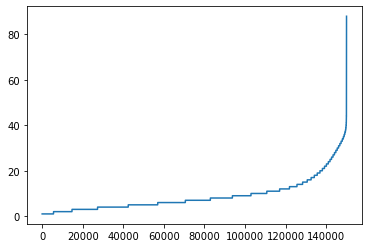

전체 :  150000
25단어 이하 :  142587


In [13]:
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print("전체 : ", len(sentence_len))
print("25단어 이하 : ", sum([int(l <= 25) for l in sentence_len]))

#### 단어 정제 및 문장 길이 줄임
* [word[:5] for word in sentence][:25]
    * 각 문장의 단어는 25개([:25]) 까지 가져옴
    * 각 단어의 길이는 5([:5])까지 가져옴 

In [14]:
sentences_new = []  # 새로운 리스트 생성 

for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
    
sentences = sentences_new   # 새로운 형태로 변환된 것을 설정 

# 문장 확인 
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


#### Tokenizer와 pad_sequences를 사용한 문장 전처리
* pad_sequences : 짧은 문장을 같은 길이의 문장(25단어)으로 바꾸기 위한 패딩을 넣는다. 
    * pad_sequences(train_X, padding='post') : 입력된 데이터에 패딩을 더한다. 
    * 'post' : 뒷쪽에 패닝을 넣는다. 
* Tokenizer : 모든 단어를 사용하지 않고 출현 빈도가 가장 높은 일부 단어만 사용하기 위해 사용
    * 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 num_words에 지정된 만큼만 숫자로 반환하고, 나머지는 0으로 반환
    * fit_on_texts(sentences) : Tokenizer에 데이터를 실제로 입력 
    * texts_to_sequences(sentences) : 문장을 입력 받아 숫자로 반환 
* 전처리된 문장 
    * 아 --> 25, 더빙 --> 884 등 5개 단어가 숫자로 변경 
    * 나머지 없는 부분은 0으로 설정 
    * 특정 단어는 빈도 수에서 상위 20,000에 들지 못해 0로 처리된다. 

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)
train_X = pad_sequences(train_X, padding='post')

print(train_X[:5])

[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


#### 감성 분석을 위한 모델 정의
* input_length=25 : 각 문장에 들어있는 25개 단어의 길이를 300의 임베딩 벡터로 변환 
* sparse_categorical_crossentropy : 여러 개의 정답 중에 하나를 맞추는 분류 문제일 경우 사용 

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


#### 감성 분석 모델 학습 

In [17]:
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Train on 120000 samples, validate on 30000 samples
Epoch 1/5
120000/120000 [==============================] - 68s 568us/sample - loss: 0.4343 - accuracy: 0.7855 - val_loss: 0.3801 - val_accuracy: 0.8216
Epoch 2/5
120000/120000 [==============================] - 65s 545us/sample - loss: 0.3250 - accuracy: 0.8471 - val_loss: 0.3842 - val_accuracy: 0.8165
Epoch 3/5
120000/120000 [==============================] - 66s 552us/sample - loss: 0.2734 - accuracy: 0.8681 - val_loss: 0.4191 - val_accuracy: 0.8103
Epoch 4/5
120000/120000 [==============================] - 66s 546us/sample - loss: 0.2307 - accuracy: 0.8874 - val_loss: 0.4863 - val_accuracy: 0.8094
Epoch 5/5
120000/120000 [==============================] - 65s 545us/sample - loss: 0.1965 - accuracy: 0.9033 - val_loss: 0.5584 - val_accuracy: 0.8048


#### 감성 분석 모델 학습 결과 확인

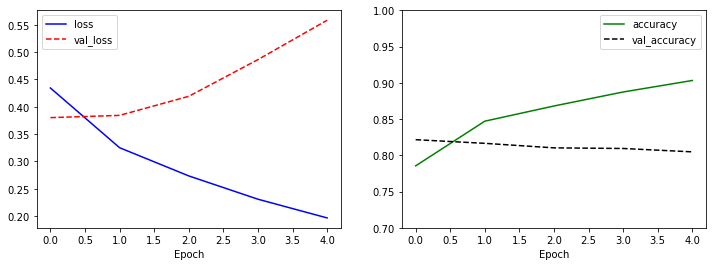

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

#### 테스트 데이터 준비(학습 데이터와 동일한 방법으로 작성)

In [22]:
test_text_X = np.array([row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0])
test_text_X = [clean_str(sentence) for sentence in test_text_X]  # 불필요한 기호 생략

# 문장을 띄어쓰기 단위로 단어 분리 
sentences = [sentence.split(' ') for sentence in test_text_X]

sentences_new = []  # 새로운 리스트 생성 

for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
    
sentences = sentences_new   # 새로운 형태로 변환된 것을 설정 

# 문장 확인 
for i in range(5):
    print(sentences[i])

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')

print(test_X[:5])

['굳', '']
['gdnto']
['뭐야', '이', '평점들은', '나쁘진', '않지만', '10점', '짜리는', '더더욱', '아니잖아']
['지루하지는', '않은데', '완전', '막장임', '돈주고', '보기에는', '']
['3d만', '아니었어도', '별', '다섯', '개', '줬을텐데', '왜', '3d로', '나와서', '제', '심기를', '불편하게', '하죠', '\\?', '\\?', '']
[[  594     1     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  357     9  4626   990    69  3348  2773     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 2110    32 12562   506  1450     1     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [17856   109 12074   244 18890    11  3365   348   468 12715     5     5
      1     0     0     0     0     0     0     0     0     0 

#### 모델 평가 

In [23]:
model.evaluate(test_X, test_Y)

50000/50000 [==============================] - 4s 80us/sample - loss: 0.5729 - accuracy: 0.7991


[0.5729142402315139, 0.79914]

#### 임의의 문장 감성 분석 결과 확인

In [33]:
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ')

test_sentences = []
now_sentence = []

for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])   # 단어를 늘려감 
    
print(test_sentences)
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=25)
print(test_X_1)

[['재미있을'], ['재미있을', '줄'], ['재미있을', '줄', '알았는데'], ['재미있을', '줄', '알았는데', '완전'], ['재미있을', '줄', '알았는데', '완전', '실망했다.'], ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무'], ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고'], ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이'], ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']]
[[ 4696     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 4696   194     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 4696   194   523     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 4696   194   523    32     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 4696   194   523    32     0     0 

In [35]:
prediction = model.predict(test_X_1)  # 2가지 경우에 대한 확률 출력 

for idx, sentence in enumerate(test_sentences):
    print(idx, sentence, prediction[idx])

0 ['재미있을'] [0.1858438  0.81415623]
1 ['재미있을', '줄'] [0.23971862 0.7602814 ]
2 ['재미있을', '줄', '알았는데'] [0.3608457  0.63915426]
3 ['재미있을', '줄', '알았는데', '완전'] [0.46016777 0.53983223]
4 ['재미있을', '줄', '알았는데', '완전', '실망했다.'] [0.46016777 0.53983223]
5 ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무'] [0.63687277 0.36312726]
6 ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고'] [0.9971956  0.00280439]
7 ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이'] [0.99775654 0.00224346]
8 ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.'] [0.99775654 0.00224346]


* 진행하면서 확률이 긍정에서 부정의 의미로 99.7%로 예측함.